In [1]:
from PIL import Image
import numpy as np
from iminuit import Minuit
from scipy.signal import savgol_filter
import pandas as pd
from scipy.optimize import minimize

import matplotlib

import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams.update({'font.size': 18})

In [2]:
import sys
sys.path.insert(0, 'utils')
from plot import plot_image, plot_limb
from image import load_image, detect_limb, smooth_limb
# from fit import CostFunction, unpack_parameters  # , LimbArcABC, LimbArc
from geometry import limb_arc

In [2]:
def plot_grad(grad, column=0):
    y = grad[:, 2000]
    y[np.isinf(y)] = 0

    yhat = savgol_filter(y, 101, 3)

    yhathat = np.diff(yhat)
    m = np.argmax(yhathat)

    plt.axvline(x=m, c='y', ls='--')

    plt.scatter(np.arange(grad.shape[0]), y)
    plt.plot(np.arange(grad.shape[0]), yhat, c='k')

    plt.show()

In [4]:
def find_break(image, y_min=0, y_max=-1, window_length=101, polyorder=3, deriv=0, delta=1.0):
    grad = np.log10(abs(np.gradient(image.sum(axis=2), axis=0)))
    grad[np.isinf(grad)] = 0
    
    breaks = []
    for i in range(image.shape[1]):
    
        y = grad[:, i]
#         y[np.isinf(y)] = 0

        yhat = savgol_filter(y, window_length=window_length,
                             polyorder=polyorder, deriv=deriv, delta=delta)

        yhathat = np.diff(yhat)
        m = np.argmax(yhathat[y_min:y_max])

        breaks += [m+y_min]
        
    return np.array(breaks)

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_69231/1108835570.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.gradient(im_arr.sum(axis=2), axis=0))))


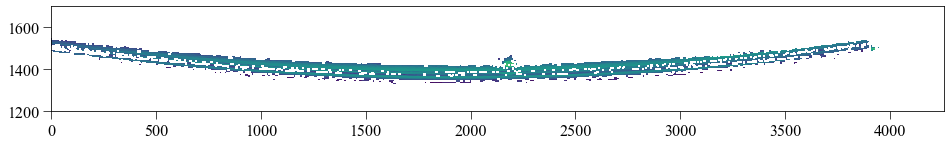

In [9]:
plt.imshow(np.log10(abs(np.gradient(im_arr.sum(axis=2), axis=0))))
ax=plt.gca()
ax.set_ylim(1200, 1700)
plt.show()

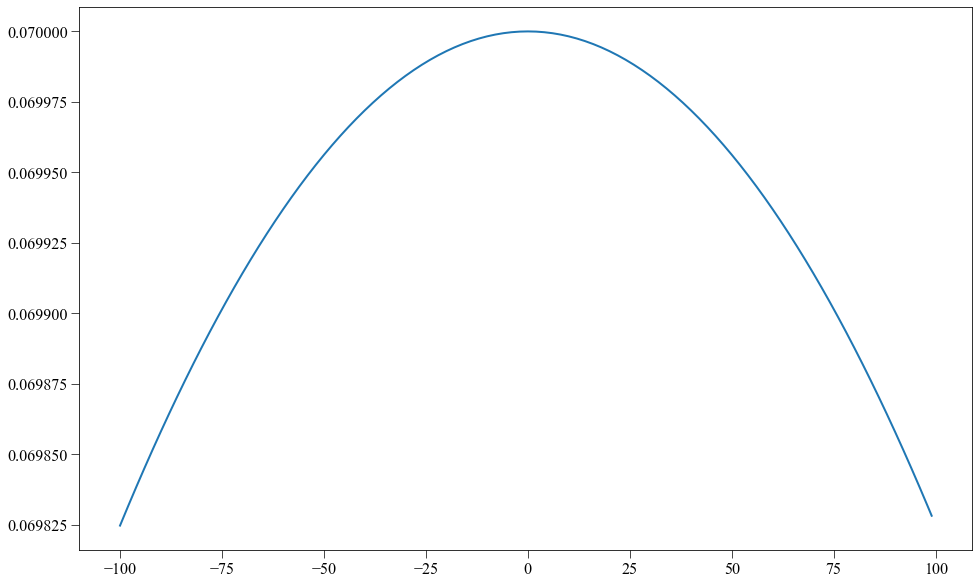

In [5]:
def intrinsic_transform(world_coords, f=1, px=1, py=1, x0=0, y0=0):
    Mi = np.array([
        [float(f)/px, 0, x0, 0],
        [0, float(f)/py, y0, 0],
        [0, 0, 1, 0]
    ])
        
    # todo allow for shear/etc.    
    
    camera_coords = []
    for i in range(len(world_coords)):
        camera_coords += [Mi @ world_coords[i, :]]
    camera_coords = np.array(camera_coords)
    
    return camera_coords


def extrinsic_transform(world_coords,
                        theta_x=0, theta_y=0, theta_z=0,
                        origin_x=0, origin_y=0, origin_z=0):
    
    """
    origin_x (world coords center in camera coords)
    """
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    rotation = Rx @ Ry @ Rz
    
    translation = np.array([origin_x, origin_y, origin_z])
    
    # see https://en.wikipedia.org/wiki/Camera_resectioning
    transform = np.zeros((4, 4))
    transform[:3, :3] = rotation
    transform[:3, 3] = translation
    transform[3, 3] = 1
        
    camera_coords = []
    for i in range(len(world_coords)):
        camera_coords += [transform @ world_coords[i, :]]
    camera_coords = np.array(camera_coords)
    
    return camera_coords


def limb_arc(x, r, h=1,
             method='resection', screen_dist=1,
             f=0.035, px=1, py=1, x0=0, y0=0,
             theta_x=0, theta_y=0, theta_z=0,
             origin_x=0, origin_y=0, origin_z=0
             ):
    
    # diffraction correction?
#     r = r * 1.2
        
    d = np.sqrt(h**2 + 2*h*r)
    theta = np.arccos(r / (r + h))

    xdcostheta = np.clip(x / (d * np.cos(theta)), -1, 1) # to avoid out of bounds
#     xdcostheta = x / (d * np.cos(theta))
    y_world = d * np.cos(np.arcsin(xdcostheta)) * np.sin(theta)
                   
    if method == 'screen':
        y_camera = y_world * screen_dist / np.sqrt(d**2 - y_world**2)
    elif method == 'resection':
        x_world = d * np.sin(np.arcsin(xdcostheta)) * np.cos(theta)
        z_world = d * np.cos(np.arcsin(xdcostheta)) * np.cos(theta)
        
        world_coords = np.ones((len(x), 4))
        world_coords[:, 0] = x_world
        world_coords[:, 1] = y_world
        world_coords[:, 2] = z_world
        # todo worth a 3d scatter demo of world coords?
        
        camera_coords = extrinsic_transform(world_coords,
                                            theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
                                            origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
        camera_coords = intrinsic_transform(camera_coords, f=f, px=px, py=py,
                                            x0=x0, y0=y0)
        
        y_camera = camera_coords[:, 1]
    
    return y_camera

y = limb_arc(np.arange(-100, 100), 1e6, method='resection')
plt.plot(np.arange(-100, 100), y)
plt.show()

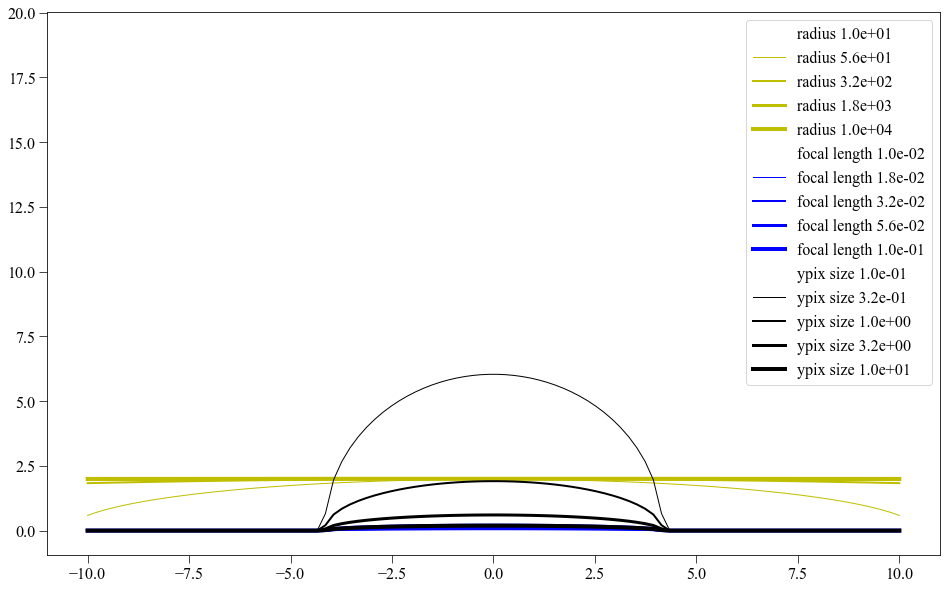

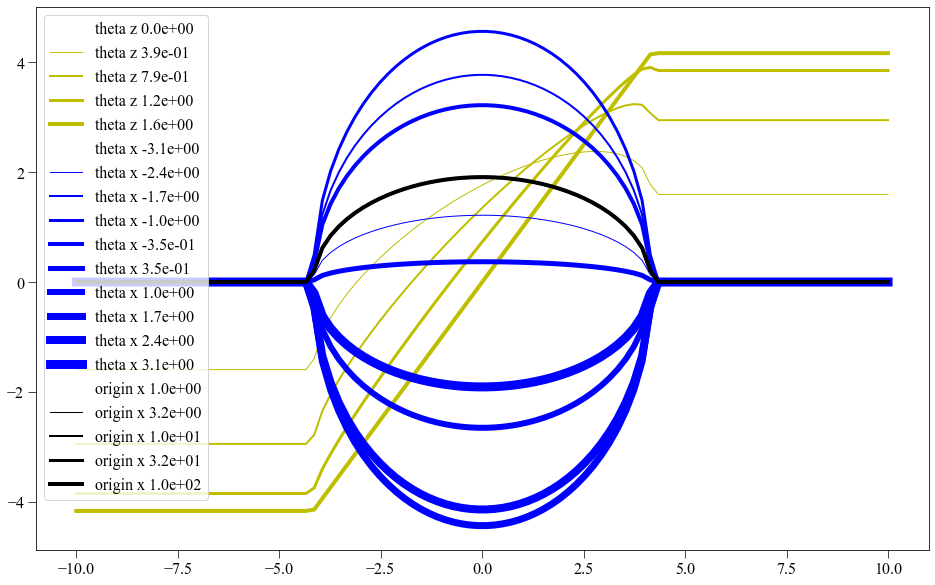

In [6]:
x = np.linspace(-10, 10, 100)

for i, r in enumerate(np.logspace(1, 4, num=5)):
#     y = limb_arc(x, r, h=1, method='screen', screen_dist=1)
    y = limb_arc(x, r, method='resection', f=1, px=1, py=1, x0=0, y0=0)
    plt.plot(x, y, label=f'radius {r:.1e}', c='y', lw=i)
    
for i, r in enumerate(np.logspace(-2, -1, num=5)):
#     y = limb_arc(x, r=10, h=1, method='screen', screen_dist=r)
    y = limb_arc(x, r=10, method='resection', f=r, px=1, py=1, x0=0, y0=0)
    plt.plot(x, y, label=f'focal length {r:.1e}', c='b', lw=i)
    
for i, r in enumerate(np.logspace(-1, 1, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=r, x0=0, y0=0)
    plt.plot(x, y, label=f'ypix size {r:.1e}', c='k', lw=i)
    
plt.legend()
plt.show()
    
for i, theta in enumerate(np.linspace(0, np.pi/2, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=0, theta_y=0, theta_z=theta,
                 origin_x=0, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'theta z {theta:.1e}', c='y', lw=i)    

for i, theta in enumerate(np.linspace(-np.pi, np.pi, num=10)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=theta, theta_y=0, theta_z=0,
                 origin_x=0, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'theta x {theta:.1e}', c='b', lw=i) 
    
for i, d in enumerate(np.logspace(0, 2, num=5)):
    y = limb_arc(x, r=10, method='resection', f=1, px=1, py=1, x0=0, y0=0,
                 theta_x=0, theta_y=0, theta_z=0,
                 origin_x=d, origin_y=0, origin_z=0)
    plt.plot(x, y, label=f'origin x {d:.1e}', c='k', lw=i) 
    
plt.legend()
plt.show()

In [3]:
iss_h = 418*1000 # up to 415-421km [418.552]
earth_r = 6.3e6

In [4]:
img = Image.open('demo/iss040e129950.jpg')
arry = img.getdata()
im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)
im_arr = im_arr.reshape((img.size[1], img.size[0], 3)) 

/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_98390/603171426.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(img.tobytes(), dtype=np.uint8)


In [5]:
breaks_def = detect_limb(im_arr)

/Users/banderson/Projects/bogs/planet-ruler/utils/image.py:19: RuntimeWarning: divide by zero encountered in log10
  grad = np.log10(grad)


In [6]:
# breaks_def = find_break(im_arr, window_length=101,
#                         polyorder=3, deriv=0, delta=1)

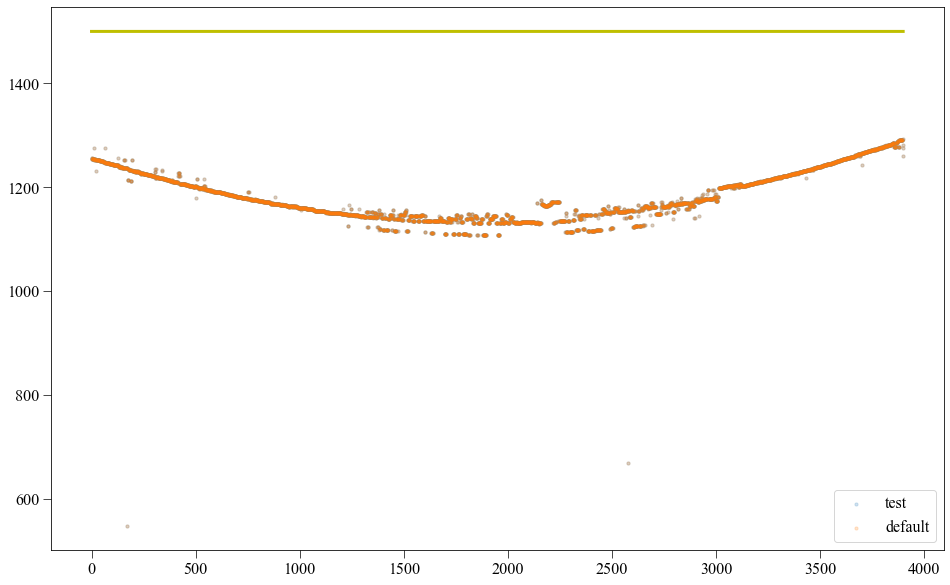

In [7]:
# breaks = find_break(im_arr, window_length=501,
#                     polyorder=1, deriv=0, delta=1)
breaks = detect_limb(im_arr, window_length=501, polyorder=1, deriv=0)

x_min = 0
x_max = 3900
target = breaks[x_min:x_max]
x = np.arange(len(target))

# x = np.arange(im_arr.shape[1])
xc = x - int(len(x)*0.5)

y = limb_arc(xc, r=6.3e6, h=1) + 1500
plt.plot(x, y, c='y', lw=3)
plt.scatter(x, target, alpha=0.2, s=10, label='test')
plt.scatter(x, breaks_def[x_min:x_max], alpha=0.2, s=10, label='default')
plt.legend()

ax=plt.gca()
# ax.set_ylim(1200, 1700)
# plt.imshow(im_arr)
plt.show()

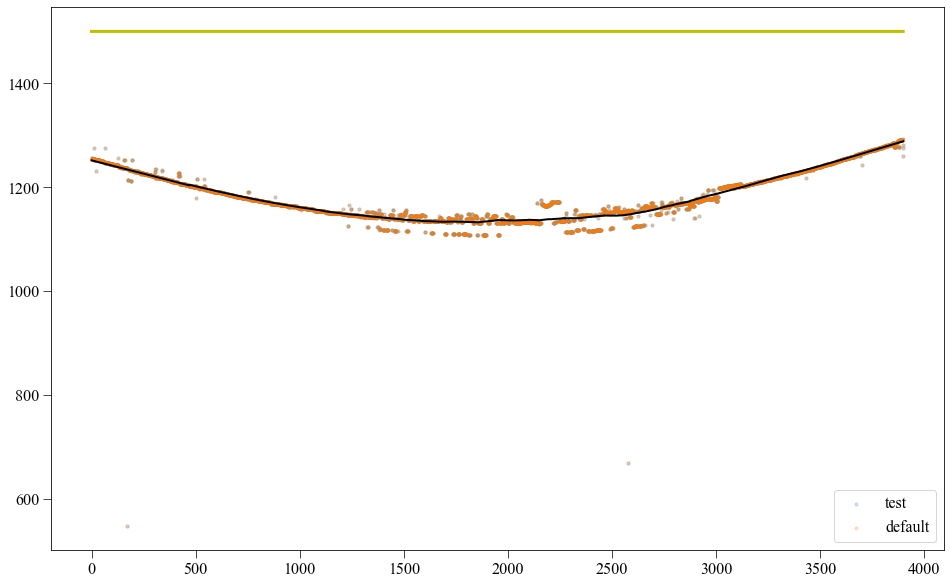

In [8]:
y = limb_arc(xc, r=6.3e6, h=1) + 1500
plt.plot(x, y, c='y', lw=3)
plt.scatter(x, target, alpha=0.2, s=10, label='test')

window_length = 601
polyorder = 1
deriv = 0
delta = 1

ysm = savgol_filter(target, window_length=window_length, polyorder=polyorder,
                    deriv=deriv, delta=delta)
plt.plot(x, ysm, c='k')

plt.scatter(x, breaks_def[x_min:x_max], alpha=0.2, s=10, label='default')
plt.legend()

target = ysm
# target = breaks[x_min:x_max]
x = np.arange(len(target))

In [9]:
# from scipy.optimize import minimize

In [10]:
truncated_init = {'r': earth_r, #6300000,
                  'h': iss_h,
                  'f': 0.035, #1.25, # change to 35mm!  0.035
                  'py': 0.00007,
                  'y0': 0,
                  'theta_x': np.pi - 6.2e-7,
                  'theta_z': 0.00031,
                  'origin_y': 809996 - 0.5
#                   'origin_y': np.sqrt(2*6300000*418000 + 418000**2)
                 }

full_init = {'r': earth_r,
        'h': iss_h,
        'f': 1,
        'px': 1,
        'py': 0.003,
        'x0': 0,
        'y0': 0,
        'theta_x': 3.141592653589793,
        'theta_y': 0,
        'theta_z': 0.0003,
        'origin_x': 0,
        'origin_y': 809996,
        'origin_z': 0}


lims = {'r': (1000000.0, 10000000.0),
        'h': (iss_h - 1000, iss_h + 1000),
        'f': (0.0, 1),
        'px': (1e-5, 1),
        'py': (1e-5, 1),
        'x0': (-np.inf, np.inf),
        'y0': (-np.inf, np.inf),
        'theta_x': (-np.pi, np.pi),
        'theta_y': (0, 0),
        'theta_z': (-np.pi, np.pi),
        'origin_x': (-np.inf, np.inf),
        'origin_y': (-np.inf, np.inf),
        'origin_z': (-np.inf, np.inf)
       }

In [11]:
# def unpack_parameters(params, template):    
#     return {key:params[i] for i,key in enumerate(template)}


# class CostFunction:
#     def __init__(self, x, target, function, fit_template, full_template):
#         self.function = function
#         self.fit_template = fit_template
#         self.full_template = full_template
#         self.x = x
#         self.target = target
        
#     def cost(self, params):
        
#         if type(params) == np.ndarray:
#             kwargs = self.full_template.copy()
#             kwargs.update(unpack_parameters(list(params), self.fit_template))
#         else:
#             kwargs = params
                
#         y_pred = self.function(self.x, **kwargs)
        
#         cost = np.sum(pow(y_pred - self.target, 2))
        
#         return cost
    
#     def evaluate(self, params):
        
#         kwargs = self.full_template.copy()
#         if type(params) == np.ndarray:
#             kwargs.update(unpack_parameters(list(params), self.fit_template))
#         else:
#             kwargs.update(params)
                
#         y_pred = self.function(self.x, **kwargs)
        
#         return y_pred
    
# # cost_function = CostFunction(x, target, limb_arc, truncated_init, full_init)
    
# # print(cost_function.cost(truncated_init))
# # print(cost_function.cost(np.array(list(truncated_init.values()))))
    

# # y = cost_function.evaluate(truncated_init)
    
# # # rough guess
# # plt.plot(x, y, lw=3, c='k')
# # plt.scatter(x, target, c='y', lw=3, alpha=0.5)
# # plt.show()

In [11]:
cost_function = CostFunction(target, limb_arc, truncated_init, full_init)

In [19]:
# results = minimize(cost_function.cost, np.array(list(bad_init.values())),
#                    method='L-BFGS-B', bounds=[lims[key] for key in init], options={'maxiter':10000})
# results = minimize(cost_function.cost, np.array(list(init.values())),
#                    method='POWELL', bounds=[lims[key] for key in init], options={'maxiter':10000})
results = minimize(cost_function.cost, np.array(list(truncated_init.values())),
                   method='Nelder-Mead', bounds=[lims[key] for key in truncated_init],
                   options={'maxiter':100000})
results

 final_simplex: (array([[ 6.29992675e+06,  4.18000118e+05,  3.16821916e-02,
         7.15447140e-05, -4.04089065e-05,  3.14159209e+00,
         3.09428436e-04,  8.09995447e+05],
       [ 6.29992675e+06,  4.18000118e+05,  3.16821905e-02,
         7.15447144e-05, -4.04089178e-05,  3.14159209e+00,
         3.09428433e-04,  8.09995447e+05],
       [ 6.29992675e+06,  4.18000118e+05,  3.16821901e-02,
         7.15447145e-05, -4.04089245e-05,  3.14159209e+00,
         3.09428432e-04,  8.09995447e+05],
       [ 6.29992675e+06,  4.18000118e+05,  3.16821904e-02,
         7.15447145e-05, -4.04089142e-05,  3.14159209e+00,
         3.09428432e-04,  8.09995447e+05],
       [ 6.29992675e+06,  4.18000118e+05,  3.16821906e-02,
         7.15447139e-05, -4.04089294e-05,  3.14159209e+00,
         3.09428430e-04,  8.09995447e+05],
       [ 6.29992675e+06,  4.18000118e+05,  3.16821912e-02,
         7.15447144e-05, -4.04089021e-05,  3.14159209e+00,
         3.09428435e-04,  8.09995447e+05],
       [ 6.299926

(1000.0, 1700.0)

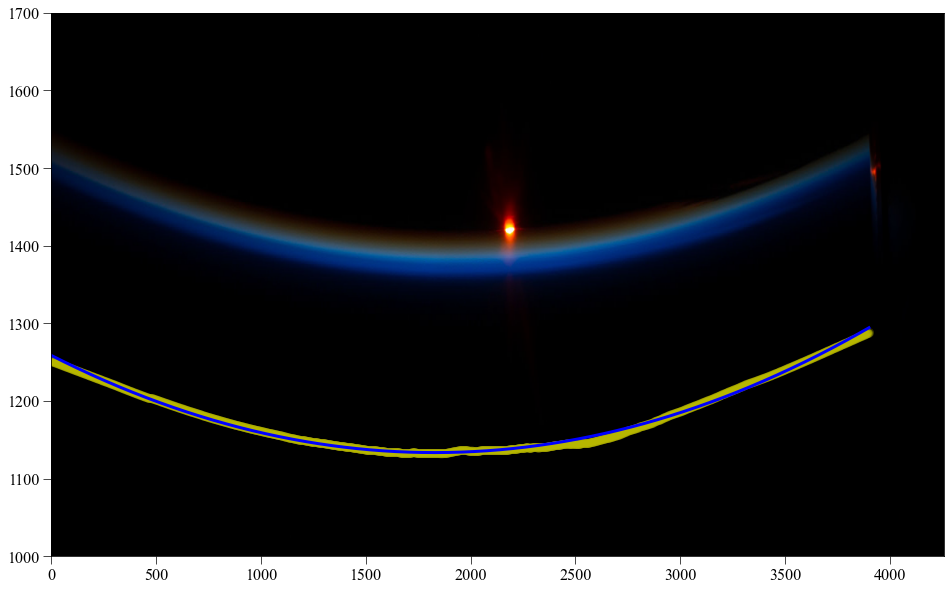

In [13]:
y = cost_function.evaluate(results.x)

plt.imshow(im_arr, origin='lower', aspect='auto')
plt.plot(np.arange(len(target)), y, lw=3, c='b')
plt.scatter(np.arange(len(target)), target, c='y', lw=3, alpha=0.1)
ax=plt.gca()
ax.set_ylim(1000, 1700)

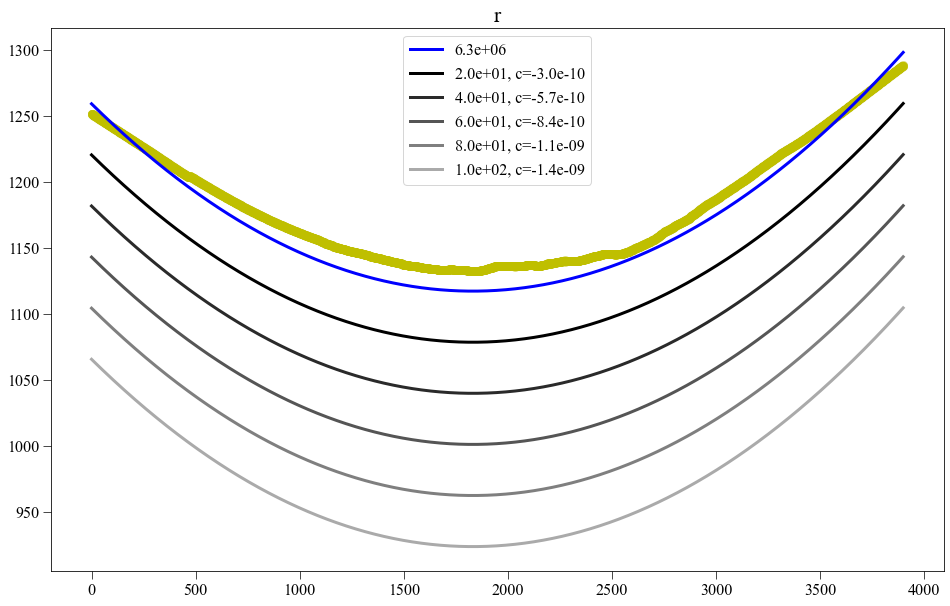

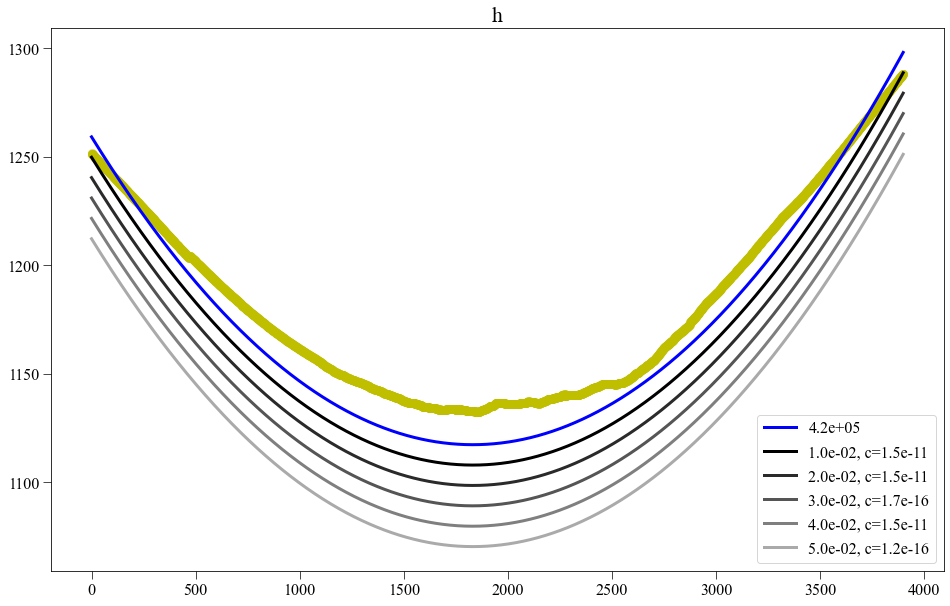

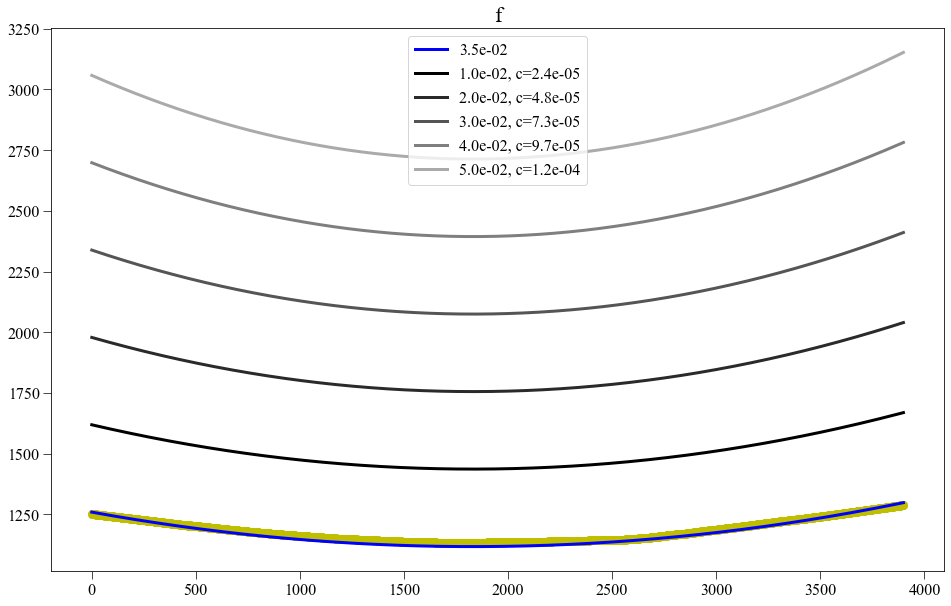

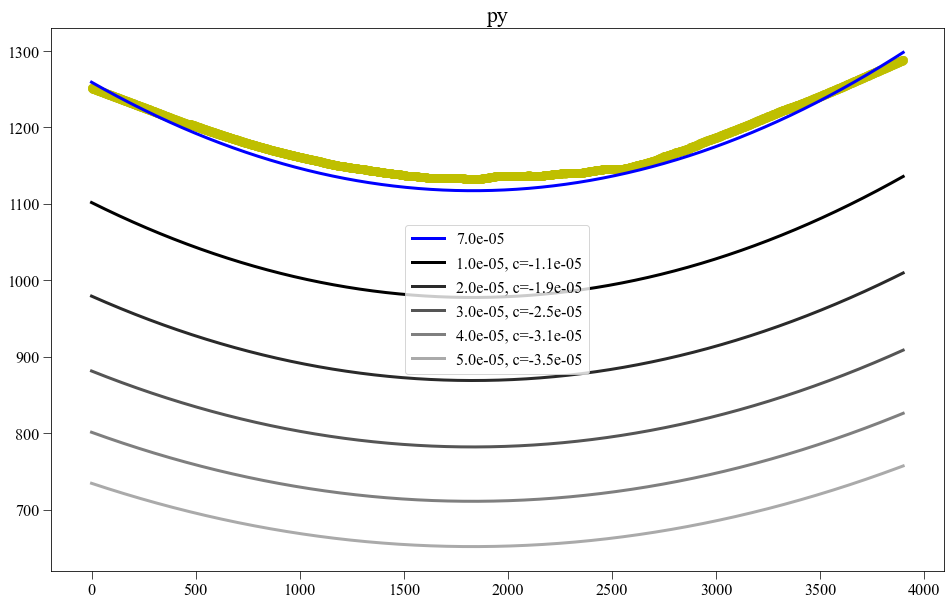

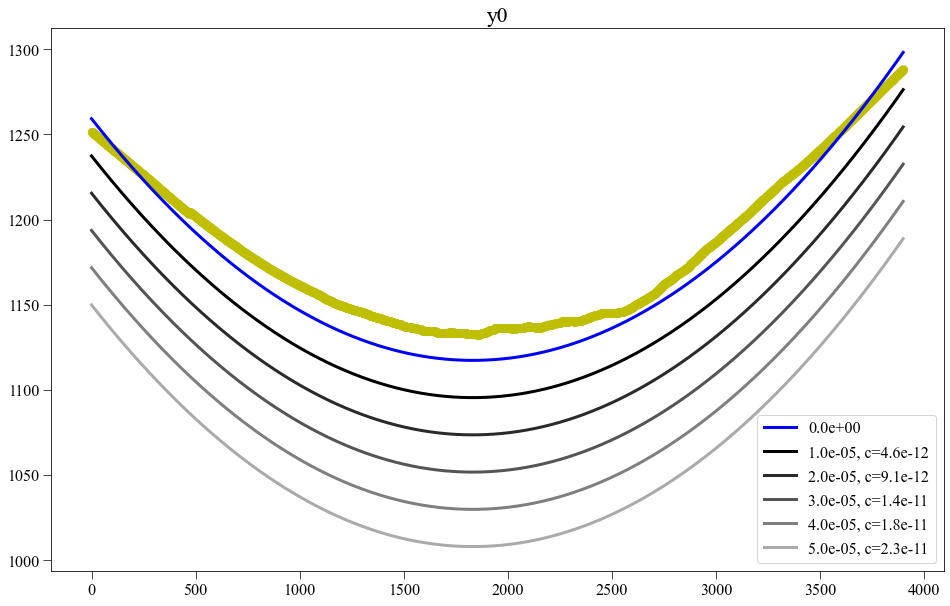

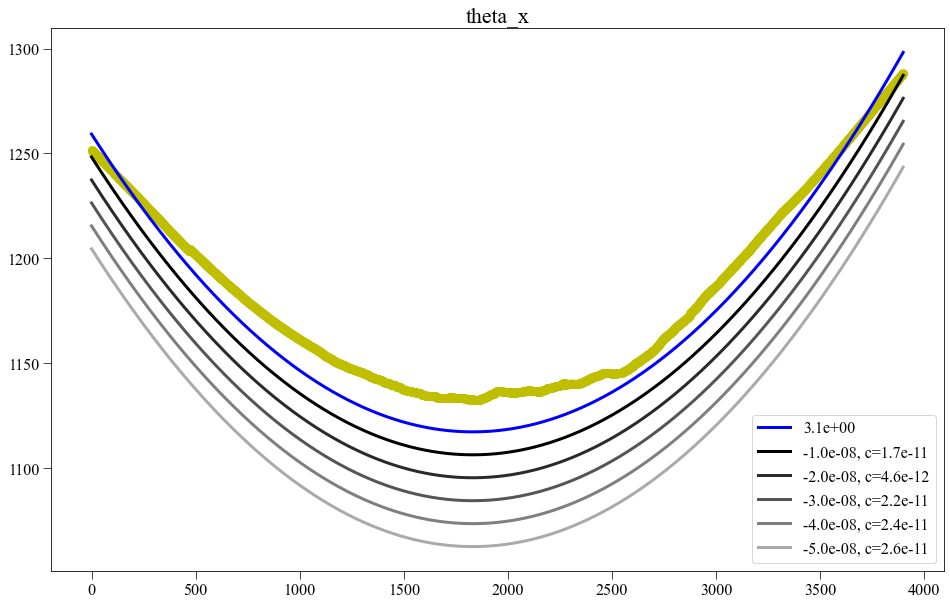

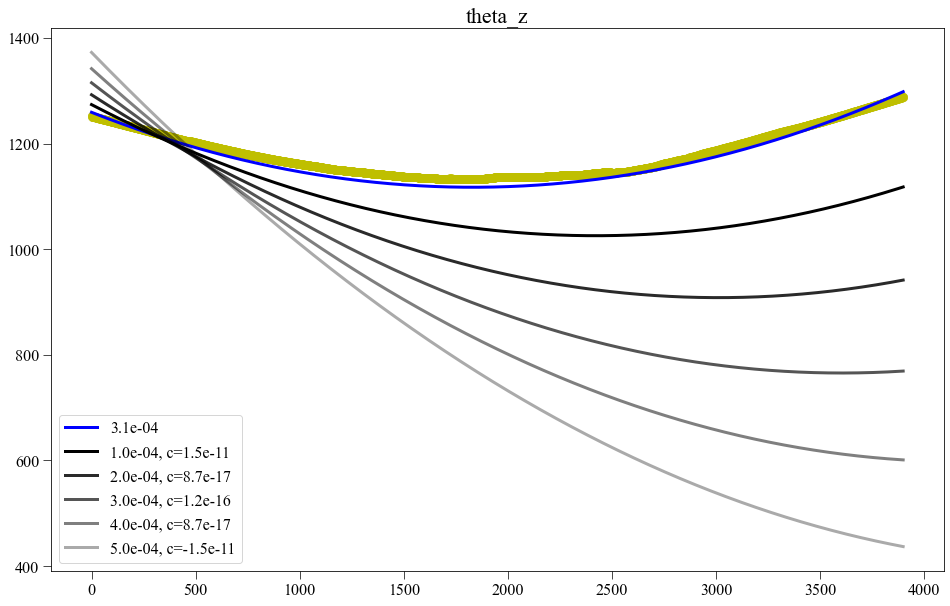

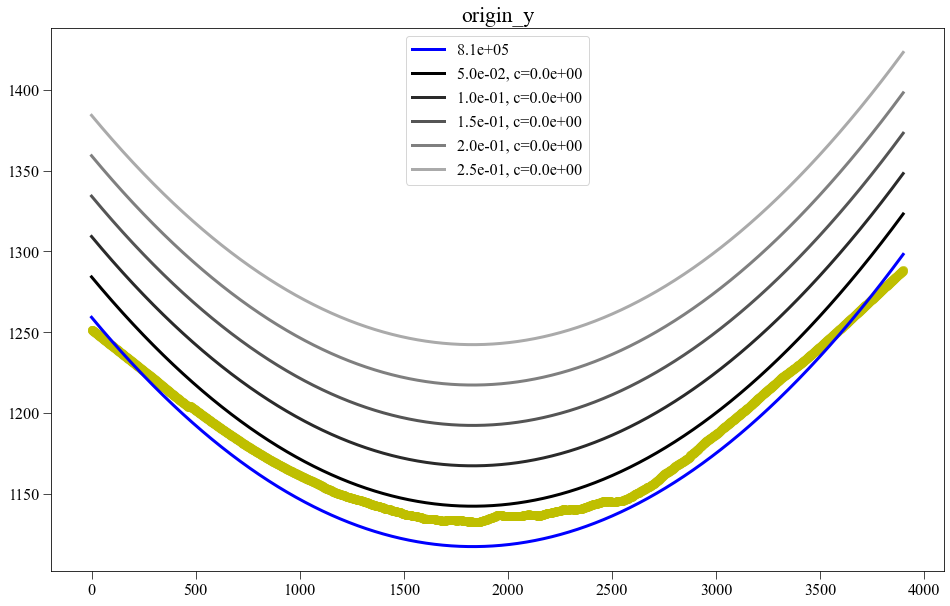

In [16]:
inc = {'r': 20, 'h': 1e-2, 'f': 0.01,
       'px': 100, 'py': 1e-5,
       'x0': 0.001, 'y0': 1e-5,
       'theta_x': -1e-8, 'theta_y': 0.0001, 'theta_z': 0.0001,
       'origin_x': 1e6, 'origin_y': 5e-2, 'origin_z': 1e6}

init = full_init.copy()
init = truncated_init.copy()
# init = unpack_parameters(results.x, truncated_init)
# init = unpack_parameters(results.x, truncated_init)

y = cost_function.evaluate(init)
curvature = np.mean(np.diff(y, n=2))

for key in init:
    plt.plot(x, y, lw=3, c='b', label=f'{init[key]:.1e}')
    
    p = init.copy()
    for i in range(5):
        p[key] += inc[key]
        yp = cost_function.evaluate(p)
        delta_curvature = np.mean(np.diff(yp, n=2)) - curvature
        plt.plot(x, yp, lw=3, c='k', alpha=(6.-i)/6, label=f'{p[key]-init[key]:.1e}, c={delta_curvature:.1e}')
    
    plt.scatter(x, target, c='y', lw=3, alpha=0.5)
    plt.title(key)
    plt.legend()
    ax=plt.gca()
#     ax.set_ylim(1300, 1700)
    plt.show()
#     break
    

In [17]:
# # resectioning 

# target = breaks[:3500]
# x = np.arange(len(target))

# # y = limb_arc(x, r=earth_r, h=iss_h, method='resection',
# #              f=1, px=1, py=3e-3, x0=0, y0=0,
# #              theta_x=np.pi, theta_y=0, theta_z=2e-4,
# #              origin_x=0, origin_y=809996, origin_z=0)
    
# # # rough guess
# # plt.plot(x, y, lw=3, c='k')
# # plt.scatter(x, target, c='y', lw=3, alpha=0.5)
# # plt.show()

# def cost_function(r, h=iss_h,
#                   f=1, px=1, py=3e-3, x0=0, y0=0,
#                   theta_x=np.pi, theta_y=0, theta_z=2e-4,
#                   origin_x=0, origin_y=809996, origin_z=0):
#     if type(r) == np.ndarray:
#         kwargs = unpack_parameters(list(r))
#         y_pred = limb_arc(x, r=r, h=h,
#                           f=f, px=px, py=py, x0=x0, y0=y0,
#                           theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
#                           origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
#     else:  
#         y_pred = limb_arc(x, r=r, h=h,
#                           f=f, px=px, py=py, x0=x0, y0=y0,
#                           theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
#                           origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)

#     return np.sum(pow(y_pred - target, 2))
    
# cost_function.errordef = Minuit.LEAST_SQUARES
# # cost_function.errordef = Minuit.LIKELIHOOD

# # m = Minuit(cost_function, r=earth_r, h=iss_h,
# #            f=1, px=1, py=3e-3, x0=0, y0=0,
# #            theta_x=np.pi, theta_y=0, theta_z=2e-4,
# #            origin_x=0, origin_y=809996, origin_z=0)

# # m = Minuit(cost_function, r=earth_r, h=iss_h,
# #            f=1, px=1, py=1, x0=0, y0=0,
# #            theta_x=np.pi, theta_y=0, theta_z=0,
# #            origin_x=0, origin_y=0, origin_z=0)

# best_fit = np.inf
# for i in accepted.index:
#     m = Minuit(cost_function, **dict(accepted.loc[i]))

#     # m.fixed = False # release all parameters
#     m.fixed["h"] = True
#     # m.fixed["x0"] = True
#     # m.fixed["y0"] = True
#     m.fixed["theta_y"] = True

#     m.limits["theta_x"] = (-np.pi, np.pi)
#     # m.limits["theta_y"] = (-np.pi, np.pi)
#     m.limits["theta_z"] = (-np.pi, np.pi)

#     m.limits["f"] = (0, None)
#     m.limits["px"] = (0, None)
#     m.limits["py"] = (0, None)

#     m.limits["r"] = (1e5, 1e8)
    
#     lims = m.limits.to_dict()
#     bounds = [lims[key] for key in lims]
    
#     m.print_level = 2
# #     m._tolerance = 1e-5
# #     m._strategy = 2
#     # m.errordef = 1
#     # m.tol = 1e-7

# #     m.simplex(ncall=int(1e6))  # run optimiser
#     m.scipy(method='L-BFGS-B', constraints=bounds)
#     print(m.values)

#     m.hesse()   # run covariance estimator
# #     print(m.errors)

#     fit = m.values.to_dict()
# #     print(fit)

# #     m.fmin
    
#     if m.fmin.fval < best_fit:
#         best_fit = m.fmin.fval
#         print('new best', best_fit)
#         best_params = fit
#     break

# ABC

In [12]:
# from scipy.stats import multivariate_normal
from abcpy.probabilisticmodels import ProbabilisticModel, Continuous, InputConnector
from abcpy.continuousmodels import Uniform, Normal
from abcpy.statistics import Identity
from abcpy.distances import Euclidean, Distance
from abcpy.inferences import RejectionABC, APMCABC
# from abcpy.backends import BackendDummy
# from abcpy.backends import BackendMPI
import pyspark
sc = pyspark.SparkContext()
from abcpy.backends import BackendSpark

from scipy.spatial.distance import cdist

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/24 16:01:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
class CostFunction:
    def __init__(self, target, function, free_parameters, init_parameter_values):
        self.function = function
        self.free_parameters = free_parameters
        self.init_parameter_values = init_parameter_values
        self.x = np.arange(len(target))
        self.target = target

    def cost(self, params):

        if type(params) == np.ndarray:
            kwargs = self.init_parameter_values.copy()
            kwargs.update(unpack_parameters(list(params), self.free_parameters))
        else:
            kwargs = params

        y = self.function(self.x, **kwargs)

        cost = np.sum(pow(y - self.target, 2))

        return cost

    def evaluate(self, params):

        kwargs = self.init_parameter_values.copy()
        if type(params) == np.ndarray:
            kwargs.update(unpack_parameters(list(params), self.free_parameters))
        else:
            kwargs.update(params)

        y = self.function(self.x, **kwargs)

        return y

In [15]:
def unpack_parameters(params, template):
    return {key: params[i] for i, key in enumerate(template)}

In [14]:
cost_function = CostFunction(target, limb_arc, truncated_init, full_init)

In [20]:
# class LimbArc(ProbabilisticModel, Continuous):

#     def __init__(self, parameters, fit_params_init, full_params_init, target, name='LimbArc'):
# #         expecting [r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z]
#         # expecting [r, h, f, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z]
#         if not isinstance(parameters, list):
#             raise TypeError('Input of Normal model is of type list')

#         self.target = target
#         self.num_x_pixels = len(target)
#         self.cost_function = CostFunction(np.arange(self.num_x_pixels), target,
#                                           limb_arc, fit_params_init, full_params_init)
        
#         self.fit_params_init = fit_params_init
#         self.full_params_init = full_params_init
        
#         self.n_fit_params = len(fit_params_init.keys())
#         if len(parameters) != self.n_fit_params:
#             raise RuntimeError(f'Input list must be of length {self.n_fit_params},'\
#                                f'containing {[key for key in fit_params_init]}.')

#         input_connector = InputConnector.from_list(parameters)
#         super().__init__(input_connector, name)

#     def _check_input(self, input_values):
#         # Check whether input has correct type or format
#         if len(input_values) != self.n_fit_params:
#             raise ValueError(f'Number of parameters of LimbArc model must be {self.n_fit_params}.')

#         # Check whether input is from correct domain
# #         r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = input_values
#         params = unpack_parameters(input_values, self.fit_params_init)
#         if params['r'] < 0 or params['h'] < 0 or params['f'] < 0 or params['py'] <= 0:
#             return False
                               
#         return True

#     def _check_output(self, values):
#         if not isinstance(values, np.array):
#             raise ValueError('This returns a bivariate array')
        
# #         if values.shape[0] != 2: 
# #             raise RuntimeError('The size of the output has to be 2.')
        
#         return True

#     def get_output_dimension(self):
# #         return self.num_x_pixels
#         return 2

#     def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
#         # Extract the input parameters
# #         r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = input_values
        
# #         mean = np.array([m1, m2])
# #         cov = self.get_cov(s1, s2, alpha)
#         # might want to implement variations rather than completely deterministic 
#         # right now we hack
        
# #         obs_pd = multivariate_normal(mean=mean, cov=cov)
# #         vector_of_k_samples = obs_pd.rvs(k)
# #         obs = limb_arc(np.arange(self.num_x_pixels), r=r, h=h,
# #                        f=f, px=px, py=py, x0=x0, y0=y0,
# #                        theta_x=theta_x, theta_y=theta_y, theta_z=theta_z,
# #                        origin_x=origin_x, origin_y=origin_y, origin_z=origin_z)
    
#         obs = self.cost_function.evaluate(unpack_parameters(input_values, self.fit_params_init))

#         # Format the output to obey API
# #         result = [np.array([x]) for x in vector_of_k_samples]
#         obs = obs.reshape(1, len(obs))
#         result = [obs for _ in range(k)]
#         return result

In [16]:
class LimbArc(ProbabilisticModel, Continuous):

    def __init__(self, target, function, parameters, free_parameters, init_parameter_values, name='LimbArc'):
        if not isinstance(parameters, list):
            raise TypeError('Input of Normal model is of type list')

        self.target = target
        self.function = function
        self.cost_function = CostFunction(target, function, free_parameters, init_parameter_values)

        self.free_parameters = free_parameters
        self.init_parameter_values = init_parameter_values

        self.n_fit_params = len(free_parameters)
        if len(parameters) != self.n_fit_params:
            raise RuntimeError(f'Input list must be of length {self.n_fit_params},'
                               f'containing {free_parameters}.')

        input_connector = InputConnector.from_list(parameters)
        super().__init__(input_connector, name)

    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != self.n_fit_params:
            raise ValueError(f'Number of parameters of LimbArc model must be {self.n_fit_params}.')

        # Check whether input is from correct domain
        # todo incorporate limit template
        params = unpack_parameters(input_values, self.free_parameters)
        if params['r'] < 0 or params['h'] < 0 or params['f'] < 0 or params['py'] <= 0:
            return False

        return True

    def _check_output(self, values):
        # todo figure this out
        if not isinstance(values, np.array):
            raise ValueError('This returns a bivariate array')

        #         if values.shape[0] != 2:
        #             raise RuntimeError('The size of the output has to be 2.')

        return True

    def get_output_dimension(self):
        # todo figure this out
        #         return self.num_x_pixels
        return 2

    def forward_simulate(self, input_values, k):
        obs = self.cost_function.evaluate(unpack_parameters(input_values, self.free_parameters))

        # Format the output to obey API
        obs = obs.reshape(1, len(obs))
        # Hack just repeat samples instead of draw
        result = [obs for _ in range(k)]
        return result

In [17]:
# class Cosine(Distance):
#     """
#     This class implements the Cosine distance between two vectors.
#     The maximum value of the distance is np.inf.
#     Parameters
#     ----------
#     statistics_calc : abcpy.statistics.Statistics
#         Statistics extractor object that conforms to the Statistics class.
#     """

#     def __init__(self, statistics_calc):
#         super(Cosine, self).__init__(statistics_calc)

#     def distance(self, d1, d2):
#         """Calculates the distance between two datasets, by computing Cosine distance between each element of d1 and
#         d2 and taking their average.
#         Parameters
#         ----------
#         d1: Python list
#             Contains n1 data points.
#         d2: Python list
#             Contains n2 data points.
#         Returns
#         -------
#         numpy.float
#             The distance between the two input data sets.
#         """
#         s1, s2 = self._calculate_summary_stat(d1, d2)

#         # compute distance between the statistics
#         dist = np.zeros(shape=(s1.shape[0], s2.shape[0]))
#         for ind1 in range(0, s1.shape[0]):
#             for ind2 in range(0, s2.shape[0]):
#                 dist[ind1, ind2] = cdist(s1[ind1, :].reshape(1,s1.shape[1]),
#                                          s2[ind2, :].reshape(1,s2.shape[1]))

#         return dist.mean()


#     def dist_max(self):
#         """
#         Returns
#         -------
#         numpy.float
#             The maximal possible value of the desired distance function.
#         """
#         return np.inf

In [20]:
r = Normal([[6358298], [1000000]], name="radius")
h = Normal([[418000], [1000]], name="height")

# f = Uniform([[0], [100]], name="focal_length")
f = Normal([[0.035], [0.005]], name="focal_length")

# px = Uniform([[0], [5]], name="pixel_width_x")
py = Uniform([[1e-5], [1]], name="pixel_width_y")

# x0 = Uniform([[-100], [100]], name="image_center_x")
y0 = Uniform([[-1], [1]], name="image_center_y")
theta_x = Uniform([[-np.pi], [np.pi]], name="rotation_x")
# theta_y = Uniform([[-np.pi], [np.pi]], name="rotation_y")
theta_z = Uniform([[-np.pi], [np.pi]], name="rotation_z")
# origin_x = Uniform([[-100], [100]], name="world_origin_x")
origin_y = Uniform([[-1500000], [1500000]], name="world_origin_y")
# origin_z = Uniform([[-100], [100]], name="world_origin_z")


# LA = LimbArc([r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z,
#              origin_x, origin_y, origin_z], num_x_pixels=len(target))
LA = LimbArc(target, limb_arc, [r, h, f, py, y0, theta_x, theta_z, origin_y],
             truncated_init, full_init,
             name='LimbArc')

# sim = LA.forward_simulate(list(truncated_init.values()), 1)
sim = LA.forward_simulate(list(unpack_parameters(results.x, truncated_init).values()), 1)

In [21]:
sim

[array([[1258.814337  , 1258.67735009, 1258.54043808, ..., 1293.9893218 ,
         1294.1444362 , 1294.29962562]])]

In [22]:
# def unpack_parameters(params):
#     r, h, f, px, py, x0, y0, theta_x, theta_y, theta_z, origin_x, origin_y, origin_z = params
    
#     return {'r':r, 'h':h, 'f':f, 'px':px, 'py':py, 'x0':x0,
#             'y0':y0, 'theta_x':theta_x, 'theta_y': theta_y,
#             'theta_z':theta_z, 'origin_x':origin_x, 'origin_y':origin_y,
#             'origin_z':origin_z}

In [23]:
statistics_calculator = Identity()
distance_calculator = Euclidean(statistics_calculator)
# distance_calculator = Cosine(statistics_calculator)
# backend = BackendDummy()
backend = BackendSpark(sc, parallelism=4)
# backend = BackendMPI(process_per_model=1)

In [24]:
obs = target.reshape(1, len(target))

In [25]:
distance_calculator.distance([obs], sim)

180.0632359578441

In [26]:
sim[0].sum()/10., np.sum(pow(sim[0]-np.mean(sim[0]), 2))

(460833.377225825, 7449836.563800694)

In [27]:
dumb_sim = [np.ones_like(sim[0]) * np.mean(sim)]
distance_calculator.distance([obs], dumb_sim)

2735.3704450680307

In [28]:
dumb_sim = [np.zeros_like(sim[0]) * np.mean(sim)]
distance_calculator.distance([obs], dumb_sim)

73843.07728472739

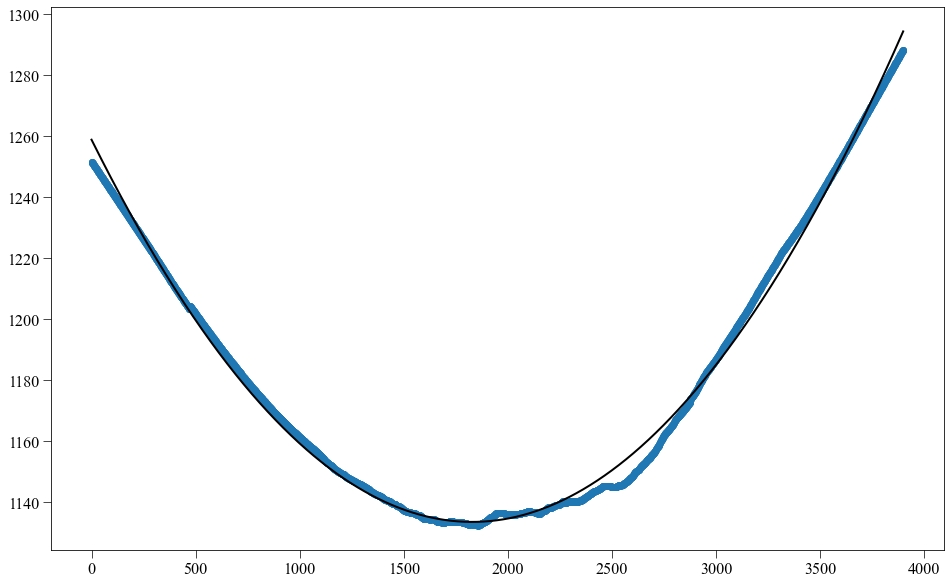

In [29]:
plt.scatter(x, obs[0])
plt.plot(x, sim[0][0], c='k')

In [30]:
sampler = RejectionABC([LA], [distance_calculator], backend, seed=1)

In [31]:
import time

In [32]:
target.shape

(3900,)

In [33]:
[[target.reshape(1, len(target))]]

[[array([[1251.64508764, 1251.54312038, 1251.44115312, ..., 1288.11286063,
          1288.2328666 , 1288.35287257]])]]

In [34]:
start = time.time()
n_samples = 4  # number of posterior samples we aim for
n_samples_per_param = 1  # number of simulations for each set of parameter values
journal = sampler.sample([[target.reshape(1, len(target))]],
                         n_samples_per_param=n_samples_per_param,
                         n_samples=n_samples,
                         epsilon=10000000)
#                          n_samples=None,
#                          n_samples_per_param=None,
#                          quantile=0.1,
#                          simulation_budget=1000)
elapsed = time.time() - start
print(f'{elapsed} seconds elapsed')

22/04/24 17:30:38 ERROR Executor: Exception in task 1.0 in stage 0.0 (TID 1)/ 4]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 601, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 430, in loads
    return pickle.loads(obj, encoding

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 0.0 failed 1 times, most recent failure: Lost task 3.0 in stage 0.0 (TID 3) (192.168.0.16 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 601, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'geometry'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 601, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 71, in read_command
    command = serializer._read_with_length(file)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'geometry'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


rk.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
22/04/24 17:30:38 ERROR Executor: Exception in task 0.0 in stage 0.0 (TID 0)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/banderson/Projects/bogs/planet-ruler/venv/lib/python3.9/

	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.ru

In [391]:
journal.number_of_simulations

[28203]

In [392]:
posterior_samples = np.array(journal.get_accepted_parameters()).squeeze()

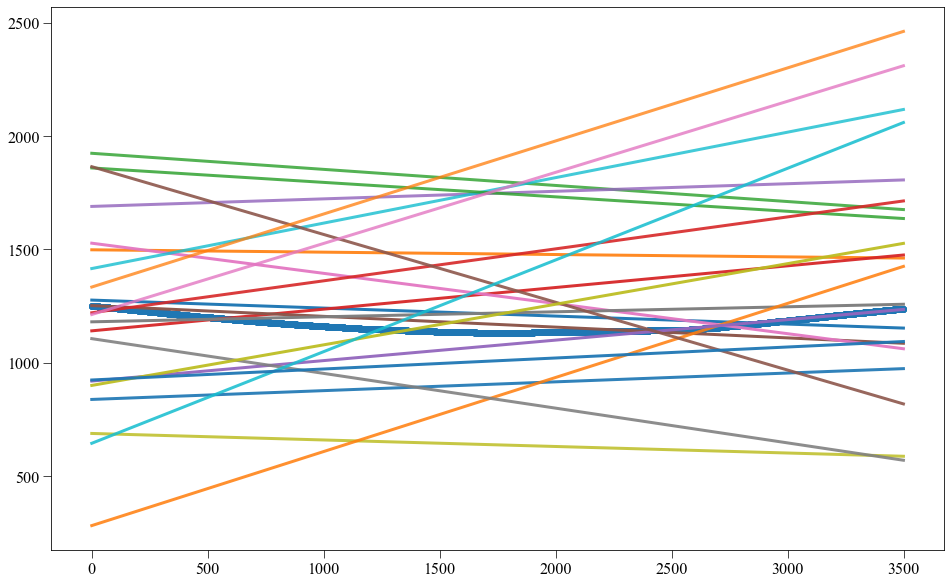

In [393]:
# plt.imshow(im_arr, origin='lower')
# plt.scatter(np.arange(len(target)), target, c='y', lw=3, alpha=0.1)
plt.scatter(x, obs[0])

for sample in posterior_samples:
    d = distance_calculator.distance([obs], LA.forward_simulate(list(sample), 1))
#     print(d)
    if d > 50000:
        continue
    arc = LA.forward_simulate(list(sample), k=1)[0][0]
    plt.plot(np.arange(len(arc)), arc, lw=3, alpha=1-d/200000.)
    
ax=plt.gca()
# ax.set_ylim(-10000, 10000)
plt.show()

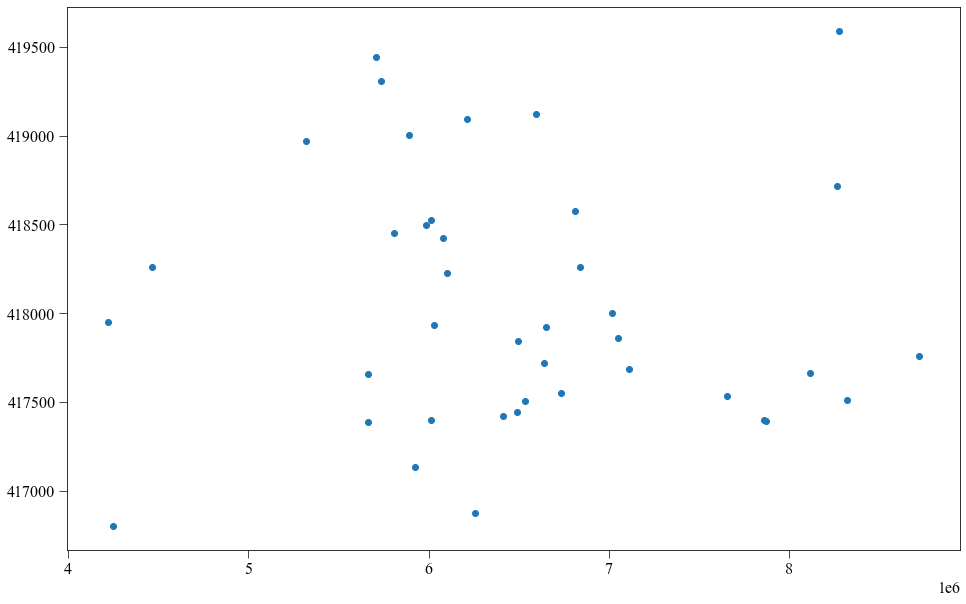

In [394]:
accepted = []
for sample in posterior_samples:    
    accepted += [unpack_parameters(sample, truncated_init)]
accepted = pd.DataFrame.from_records(accepted)
plt.scatter(accepted['r'], accepted['h'])
plt.show()

In [395]:
accepted.describe()

,r,h,f,py,y0,theta_x,theta_z,origin_y
count,4.000000e+01,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01
mean,6.495870e+06,418044.982128,0.035445,0.575833,-0.006620,0.389384,0.122334,1.556976e+04
std,1.068906e+06,708.551952,0.005145,0.262094,0.341665,1.681811,1.783635,9.710296e+05
min,4.218192e+06,416802.570332,0.027043,0.072919,-0.852706,-2.467467,-3.087648,-1.409409e+06
25%,5.914657e+06,417507.174654,0.031662,0.388699,-0.173864,-1.287691,-1.364561,-9.022401e+05
50%,6.453117e+06,417891.632082,0.035725,0.568483,0.021994,0.843285,0.234658,-1.789974e+04
75%,7.028023e+06,418503.680423,0.039693,0.767343,0.145964,1.730761,1.681390,8.879443e+05
max,8.723358e+06,419587.513495,0.045483,0.998690,0.632044,3.092648,3.046369,1.452592e+06


In [396]:
accepted.to_csv('mc_accepted.csv', index=False)

In [402]:
for i in accepted.index:
    d = distance_calculator.distance([obs], LA.forward_simulate(list(accepted.loc[i].values), 1))
#     print(d)
#     break

In [409]:
best_fit = np.inf
for i in accepted.index:
    d = distance_calculator.distance([obs], LA.forward_simulate(list(accepted.loc[i].values), 1))
#     if d > 100000:
#         continue
    
    results = minimize(cost_function.cost, accepted.loc[i].values,
                       method='Nelder-Mead', bounds=[lims[key] for key in truncated_init],
                       options={'maxiter':500000})
    print(results.success, results.message)
    if results.fun < best_fit:
        best_fit = results.fun
        print('new best', results.fun)
        best_params = results.x
        

True Optimization terminated successfully.
new best 4325771.820755856
True Optimization terminated successfully.
new best 4207481.488176599
True Optimization terminated successfully.


/var/folders/bt/hcx3fsms41nfk08g1d3xy8t40000gn/T/ipykernel_39155/2744662849.py:7: OptimizeWarning: Initial guess is not within the specified bounds
  results = minimize(cost_function.cost, accepted.loc[i].values,


True Optimization terminated successfully.
new best 4203430.1138474
True Optimization terminated successfully.
True Optimization terminated successfully.
new best 27763.643472675045
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
True Optimization terminated successfully.
T

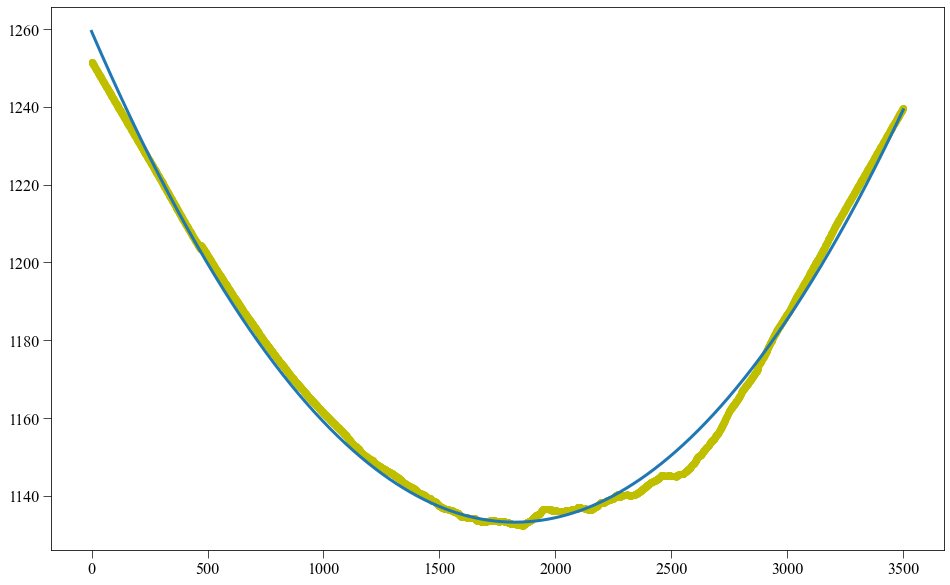

In [410]:
plt.scatter(x, obs[0], c='y')

arc = LA.forward_simulate(list(best_params), k=1)[0][0]
plt.plot(np.arange(len(arc)), arc, lw=3)
    
ax=plt.gca()
plt.show()

In [411]:
unpack_parameters(best_params, truncated_init)

{'r': 8620649.127231497,
 'h': 417024.85294094135,
 'f': 0.037448457207622604,
 'py': 0.00020018213668763276,
 'y0': -0.7581902363120345,
 'theta_x': 1.9165870042271989,
 'theta_z': 0.002155120068271542,
 'origin_y': 2710957.852720891}